In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

import os, sys
sys.path.append('..')

In [7]:
targets = ['Cases']
result_folder = '../results/TFT_baseline'
figPath = os.path.join(result_folder, 'figures')
results = pd.read_csv(os.path.join(figPath, 'predictions.csv'))
results.head()

,FIPS,TimeFromStart,Predicted_Cases,Cases,Date,split
0,10001,13,7.0,0.0,2020-03-13,train
1,10003,13,17.0,0.0,2020-03-13,train
2,10005,13,9.0,0.0,2020-03-13,train
3,1001,13,3.0,0.0,2020-03-13,train
4,1003,13,10.0,0.0,2020-03-13,train


In [8]:
results['Date'] = pd.to_datetime(results['Date'])
train = results[results['split']=='train']
validation = results[results['split']=='validation']
test = results[results['split']=='test']

In [12]:
df = train.groupby('Date')[['Predicted_Cases', 'Cases']].aggregate('sum').reset_index()

In [18]:
print('Dates with largest errors')
df['Error'] = abs (df['Predicted_Cases']- df['Cases'])
df.sort_values(by='Error', ascending=False, inplace=True)
df.head(5)

Dates with largest errors


,Date,Predicted_Cases,Cases,Error
542,2021-09-06,199999.0,51980.0,148019.0
543,2021-09-07,131697.0,235028.0,103331.0
287,2020-12-25,200698.0,100257.5,100440.5
301,2021-01-08,196379.0,285715.0,89336.0
300,2021-01-07,215277.0,298632.0,83355.0


# Plot train validation test

In [9]:
from Class.Plotter import *

plotter = PlotResults(figPath, targets, figsize=(12.5, 7))

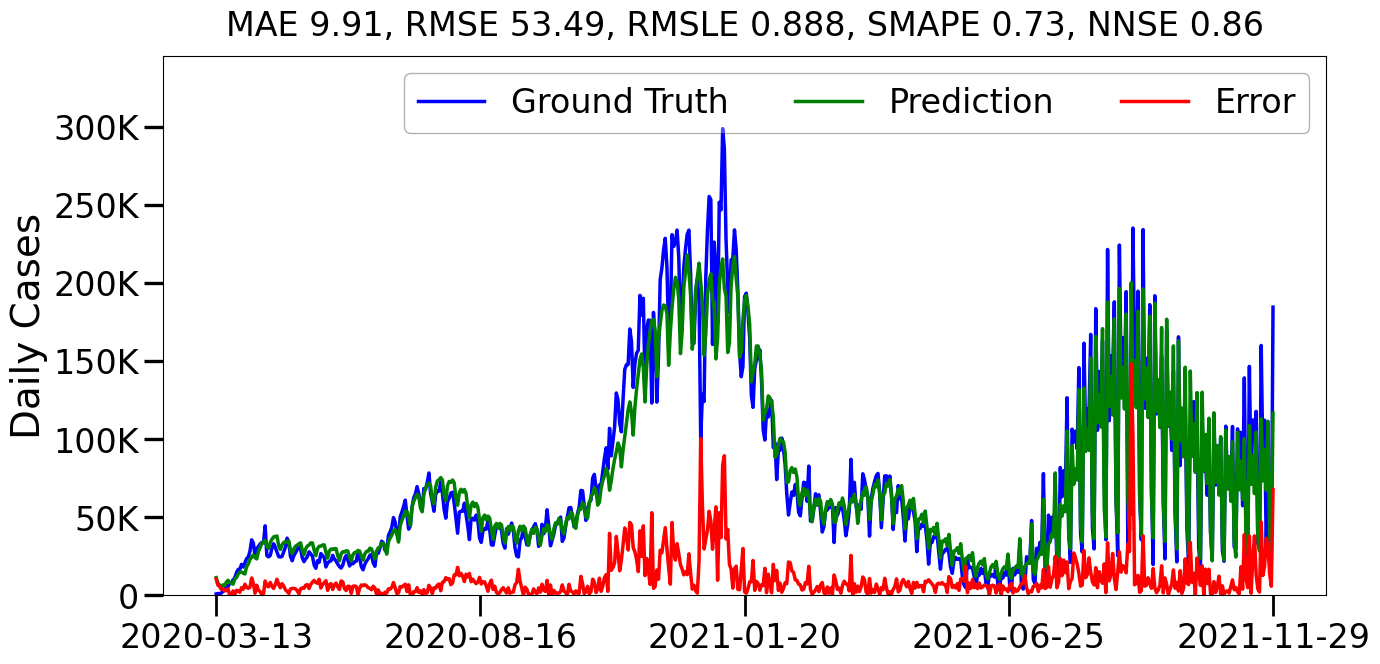

[<Figure size 1500x700 with 1 Axes>]

In [7]:
# plotter.figsize = (15, 7)
# plotter.summed_plot(train, type='Train', save=True)
plotter.summed_plot(train, type='Train_error', save=True, plot_error=True)

In [ ]:
plotter.summed_plot(validation, type='Validation', save=True)

In [ ]:
plotter.summed_plot(test, type='Test', save=True)

In [ ]:
plotter.summed_plot(test, type='Test', save=True)

# Combine train test

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 7))
# x_column = 'Date'
# target = "Cases"
# data = [train, test]

# for index in range(2):
#     ax = axes[index]
#     df = data[index]
    
#     mae, rmse, rmsle, smape, nnse = calculate_result(df[target], df[f'Predicted_{target}'])
#     title = f'MAE {mae:0.3g}, RMSE {rmse:0.3g}, RMSLE {rmsle:0.3g}, SMAPE {smape:0.3g}, NNSE {nnse:0.3g}'
    
#     # if index == 0: ax.set_title(f'Train: {title}')
#     ax.set_title(title, pad=15)
    
#     df = df.groupby([x_column])[[f'Predicted_{target}', target]].aggregate('sum').reset_index()
#     ax.plot(df[x_column], df[target], color='blue', label='Ground Truth', linewidth=2)
#     ax.plot(df[x_column], df[f'Predicted_{target}'], color='green', label='Prediction', linewidth=2)

#     _, y_max = ax.get_ylim()
#     ax.set_ylabel(f'Daily {target}')
#     ax.set_ylim(0, y_max*1.1)

#     x_first_tick = df[x_column].min()
#     x_last_tick = df[x_column].max()
#     x_major_ticks = DATE_TICKS
#     ax.set_xticks(
#         [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
#     )

#     # for tick in ax.get_xticklabels():
#     #     tick.set_rotation(15)
#     if y_max>1e3:
#         label_text = [] 
#         for loc in ax.get_yticks():
#             if loc == 0:
#                 label_text.append('0')
#             else:
#                 label_text.append(f'{loc/1e3:0.5g}K') 

#         ax.set_yticklabels(label_text)
    
    # if index==0:
    #     ax.legend(loc='upper left', framealpha=0.3, edgecolor="black")

# legend_labels = ax.get_legend_handles_labels()[-1]
# fig.legend(
#     labels=legend_labels, loc='upper left', bbox_to_anchor=(0.35, 0.01), 
#     ncol=len(legend_labels), bbox_transform=fig.transFigure, edgecolor="black"
# )
# fig.supylabel('Daily Cases', x=0.01)

## tight layout changes y axis values
# # fig.tight_layout() # might change y axis values
# plt.savefig(os.path.join(figPath, 'Train_Test_combined.jpg'), dpi=DPI, bbox_inches="tight")
# plt.show()

# Combine Splits

In [7]:
split_names =  ['Rising 3rd Wave', 'Falling 3rd Wave', 'Post 3rd Wave']

In [8]:
splits = []
for split in range(1, 4):
    result_folder = f'../results/TFT_split_{split}/'
    figPath = os.path.join(result_folder, 'figures')
    results = pd.read_csv(os.path.join(figPath, 'predictions.csv'))
    results['Date'] = pd.to_datetime(results['Date'])

    validation = results[results['split']=='validation']
    test = results[results['split']=='test']
    splits.append(test)

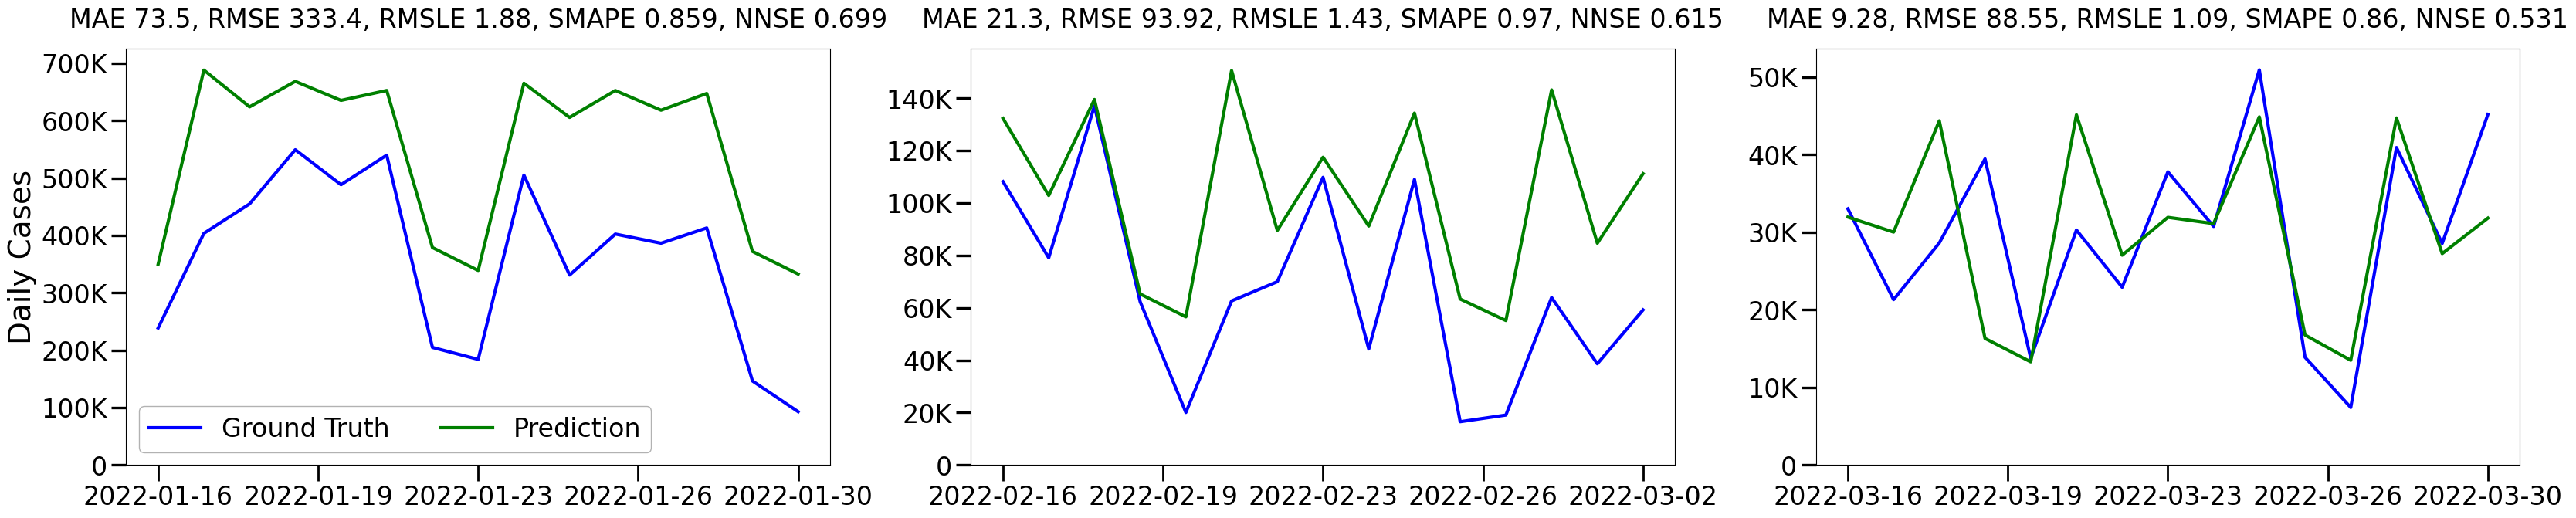

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(42, 7))
x_column = 'Date'
target = "Cases"
for index in range(3):
    ax = axes[index]
    df = splits[index]

    mae, rmse, rmsle, smape, nnse = calculate_result(df[target], df[f'Predicted_{target}'])
    title = f'MAE {mae:0.3g}, RMSE {rmse:0.4g}, RMSLE {rmsle:0.3g}, SMAPE {smape:0.3g}, NNSE {nnse:0.3g}'
    
    ax.set_title(f'{split_names[index]}\n{title}', pad=20)
    df = df.groupby([x_column])[[f'Predicted_{target}', target]].aggregate('sum').reset_index()
    ax.plot(df[x_column], df[target], color='blue', label='Ground Truth', linewidth=3)
    ax.plot(df[x_column], df[f'Predicted_{target}'], color='green', label='Prediction', linewidth=3)

    _, y_max = ax.get_ylim()
    ax.set_ylim(0, y_max*1.01)

    x_first_tick = df[x_column].min()
    x_last_tick = df[x_column].max()
    x_major_ticks = DATE_TICKS
    ax.set_xticks(
        [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
    )

    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(15)
    if y_max>2e3:
        label_text = [] 
        for loc in ax.get_yticks():
            if loc == 0:
                label_text.append('0')
            else:
                label_text.append(f'{loc/1e3:0.5g}K') 

        ax.set_yticklabels(label_text)
    
    if index==0:
        ax.legend(loc='lower left', framealpha=0.3, edgecolor="black", ncol=2)

# fig.legend(
#     labels=['Ground Truth', 'Prediction'], loc='upper left', bbox_to_anchor=(0.39, 0), 
#     ncol=2, bbox_transform=fig.transFigure, edgecolor="black"
# )
axes[0].set_ylabel('Daily Cases')

# tight layout is changing y axis values
fig.tight_layout() # might change y axis values
plt.savefig(os.path.join(figPath, 'Test_splits.jpg'), dpi=DPI, bbox_inches="tight")
plt.show()

In [ ]:
df = pd.read_csv('../2022_May_cleaned/Total.csv')[['FIPS', 'Date', 'Cases']]
df = df.groupby(['Date'])['Cases'].aggregate('sum').reset_index()

In [ ]:
baseline = df[(df['Date']>='2021-12-15') & (df['Date']<='2021-12-29')]
first_wave = df[(df['Date']>='2022-01-16') & (df['Date']<='2022-01-30')]
second_wave = df[(df['Date']>='2022-02-16') & (df['Date']<='2022-03-02')]
third_wave = df[(df['Date']>='2022-03-16') & (df['Date']<='2022-03-30')]

for data in [baseline, first_wave, second_wave, third_wave]:
    print(data.describe())